In [4]:
import starry
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

import theano
theano.config.gcc__cxxflags += " -fexceptions"

starry.config.lazy = False
starry.config.quiet = True

Text(0, 0.5, 'Flux [normalized]')

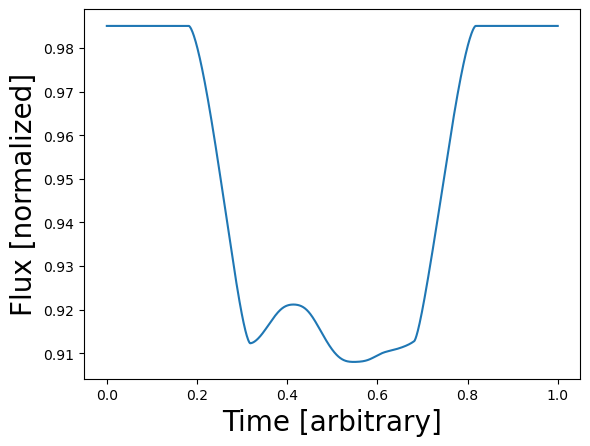

In [5]:
loaded_light_curve = np.load("light_curve_1.npy")
loaded_time=np.load("time_lc_1.npy")

flux=loaded_light_curve
time=loaded_time


plt.plot(time, flux)
plt.xlabel("Time [arbitrary]", fontsize=20)
plt.ylabel("Flux [normalized]", fontsize=20)


--- Running Naive Spot Model (Static Star Longitude Proxy, Modified Proxies) ---
Estimated total transit duration: 0.4995 days
Using transit region for analysis: t=[0.2452, 0.7548]
1) Estimated Transit Center Time (Midpoint): 0.5000
Identified bump region (d1f rule) from t=0.3243 to t=0.5475
   Bump Duration Proxy: 0.2232 days
3) Estimated Spot Radius Proxy (R*) [Rp * (Td/Tt) * 2]: 0.0894
   Time diff (t_peak - t_center): -0.0866 days
   Arg for arcsin (2*delta_t / transit_dur): -0.3467
4) Estimated Spot Longitude Proxy (Static Star): -20.29 deg
   Peak flux in bump region at t=0.4134: 0.921201
   Interpolated flux at peak time: 0.910737
   Bump height (relative to interp.): 1.05e-02
   Transit depth (baseline - min_smooth): 4.38e-02
   Naive Contrast Proxy (Height / Depth): 0.2390
   Applying correction factor (Rp/Rspot)^2 = (0.100/0.089)^2 = 1.252
   Raw Estimated Spot Contrast Proxy |ΔI/I|: 0.2991
2) Final Estimated Spot Contrast Proxy |ΔI/I| (capped): 0.2991


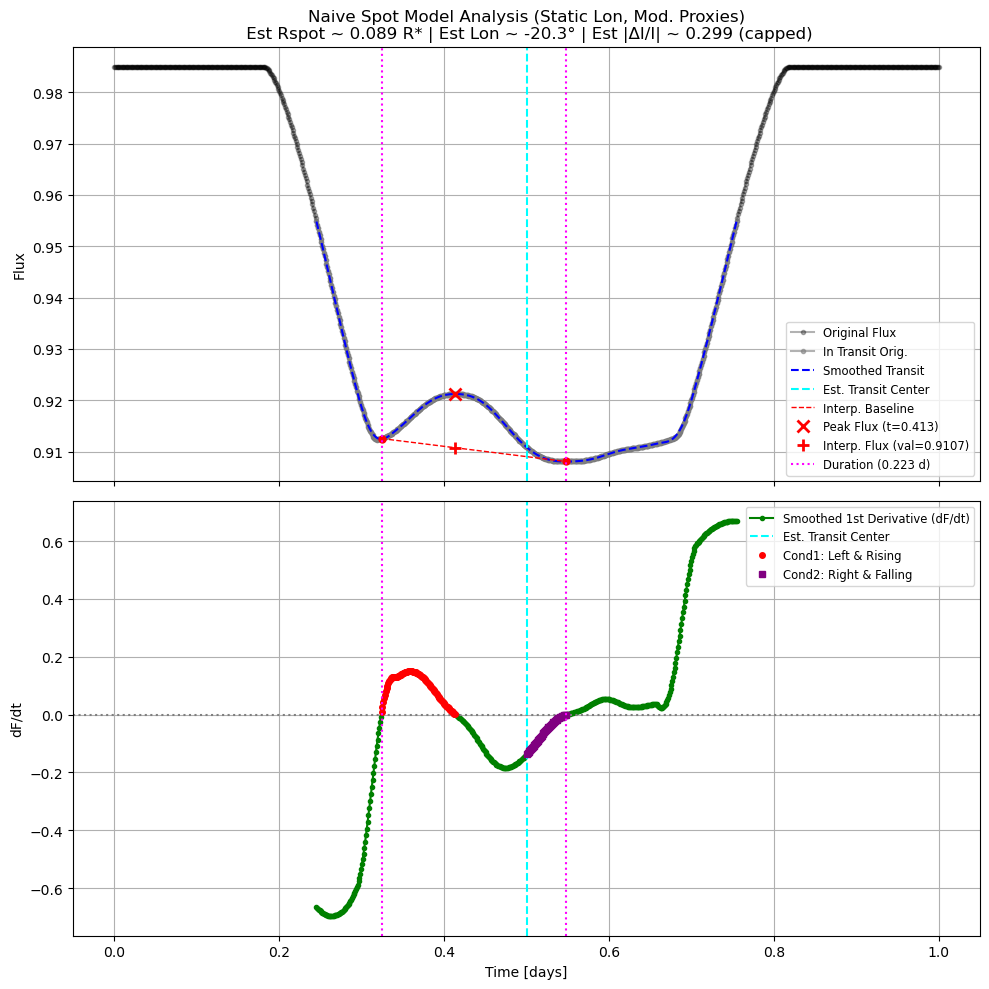


--- Generating Estimated Spot Map Visualization ---
Plotting with: Rspot/R*=0.089 rad, |ΔI/I|=0.299, lat=0.0, lon=-20.29


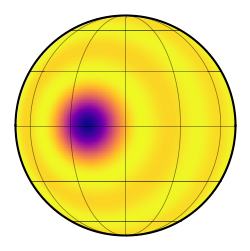

<Figure size 640x480 with 0 Axes>

--- Naive Spot Model Finished ---

Summary of Naive Spot Physical Proxies (Static Star Lon, Modified):
- center_time: 0.5000
- duration_proxy: 0.2232
- spot_radius_proxy: 0.0894
- spot_longitude_deg: -20.29
- spot_intensity_proxy: 0.2991 (capped)
- t_start_bump: 0.3243
- t_end_bump: 0.5475


In [13]:
import starry
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import warnings # To handle potential arcsin domain errors


#----------------------------------------------------
# 3. Function to Plot Estimated Spot Map (Unchanged)
#----------------------------------------------------
def plot_estimated_spot_map(results, ydeg_plot=10, inc_plot=90.0, obl_plot=0.0, lat_plot=0.0, cmap_plot='plasma'):
    """
    Generates a simple starry map visualization based on estimated parameters.
    Uses estimated longitude if available, otherwise defaults to 0.
    """
    print("\n--- Generating Estimated Spot Map Visualization ---")

    radius = results.get('spot_radius_proxy', np.nan)
    # Use the FINAL capped intensity for plotting
    contrast = results.get('spot_intensity_proxy', np.nan)
    lon_plot = results.get('spot_longitude_deg', 0.0)
    if np.isnan(lon_plot): lon_plot = 0.0

    if np.isnan(radius) or np.isnan(contrast):
        print("WARNING: Cannot plot map. Missing estimated radius or intensity.")
        return

    print(f"Plotting with: Rspot/R*={radius:.3f} rad, |ΔI/I|={contrast:.3f}, lat={lat_plot}, lon={lon_plot:.2f}")
    try:
        map_plot = starry.Map(ydeg=ydeg_plot, inc=inc_plot, obl=obl_plot)
        map_plot.spot(contrast=contrast, radius=radius, lat=lat_plot , lon = lon_plot)
        map_plot.show(cmap=cmap_plot, projection='ortho')
        fig = plt.gcf()
        fig.suptitle(f"Estimated Spot Visualization\n(Assumed lat={lat_plot}°, Est lon={lon_plot:.1f}°, Est |ΔI/I|={contrast:.3f})")
        plt.show()
    except Exception as e:
        print(f"ERROR generating plot map: {e}")


#----------------------------------------------------
# 2. Modified Naive Spot Model (Static Star Longitude + Robust Proxies)
#----------------------------------------------------
def naive_spot_model_static_lon(time, flux, occultor_radius=0.272, plot_results=True):
    """
    Analyzes a light curve, estimates transit center as midpoint, estimates bump
    duration (d1f rule), spot radius proxy (duration ratio * 2), spot longitude proxy
    (timing offset mapped via arcsin), and intrinsic spot intensity/contrast proxy
    (area-corrected contrast, capped). Assumes a static star (no rotation effect on lon).

    Args:
        time (array): Time values of the light curve.
        flux (array): Flux values of the light curve.
        occultor_radius (float): Radius of the planet/occultor in units of R*.
        plot_results (bool): If True, plots the analysis steps & estimated map.

    Returns:
        dict or None: Results dictionary or None.
    """
    results = {}
    print("\n--- Running Naive Spot Model (Static Star Longitude Proxy, Modified Proxies) ---")

    # --- Identify Transit & Duration ---
    baseline_flux = np.median(flux)
    all_transit_indices = np.where(flux < baseline_flux)[0]
    if len(all_transit_indices) < 10: print("ERROR: Could not clearly identify transit dip."); return None
    blocks = np.split(all_transit_indices, np.where(np.diff(all_transit_indices) != 1)[0]+1)
    longest_block = max(blocks, key=len, default=[])
    if len(longest_block) < 10: print("ERROR: Longest block below baseline too short."); return None
    t_start_contig_idx, t_end_contig_idx = longest_block[0], longest_block[-1]
    transit_duration_total = np.nan
    if t_end_contig_idx > t_start_contig_idx:
         transit_duration_total = time[t_end_contig_idx] - time[t_start_contig_idx]
         print(f"Estimated total transit duration: {transit_duration_total:.4f} days")
    else: print("ERROR: Could not determine total transit duration."); return None
    t_start_idx = max(0, t_start_contig_idx - 5)
    t_end_idx = min(len(time) - 1, t_end_contig_idx + 5)
    in_transit_time = time[t_start_idx:t_end_idx+1]
    in_transit_flux = flux[t_start_idx:t_end_idx+1]
    if len(in_transit_flux) < 10: print("ERROR: Not enough points in transit after buffering."); return None
    print(f"Using transit region for analysis: t=[{in_transit_time[0]:.4f}, {in_transit_time[-1]:.4f}]")

    # --- Smooth the data and Calculate Derivatives ---
    window_length = max(7, int(0.1 * len(in_transit_flux)))
    if window_length % 2 == 0: window_length += 1
    polyorder = 3
    try:
        smoothed_flux = savgol_filter(in_transit_flux, window_length=window_length, polyorder=polyorder)
        d1f_smooth = np.gradient(smoothed_flux, in_transit_time)
    except ValueError as e: print(f"ERROR: Smoothing/derivative failed ({e})."); return None

    # --- Estimate Transit Center Time ---
    transit_center_time = (in_transit_time[0] + in_transit_time[-1]) / 2.0
    results['center_time'] = transit_center_time
    print(f"1) Estimated Transit Center Time (Midpoint): {transit_center_time:.4f}")

    # --- Calculate Bump Duration, Proxies ---
    duration_proxy = np.nan; t_start_bump = np.nan; t_end_bump = np.nan
    spot_radius_proxy = np.nan; spot_intensity_proxy = np.nan; spot_longitude_deg = np.nan # Initialize intensity proxy
    bump_indices_local = []; t_peak = np.nan; f_peak = np.nan; f_interp = np.nan
    f_start_bump = np.nan; f_end_bump = np.nan; cond1 = None; cond2 = None

    is_left = in_transit_time < transit_center_time
    is_right = in_transit_time > transit_center_time
    is_rising = d1f_smooth > 0
    is_falling = d1f_smooth < 0
    cond1 = is_left & is_rising
    cond2 = is_right & is_falling
    is_bump_region = cond1 | cond2
    bump_indices_local = np.where(is_bump_region)[0]

    if len(bump_indices_local) > 1:
        start_bump_idx_local = bump_indices_local[0]
        end_bump_idx_local = bump_indices_local[-1]
        t_start_bump = in_transit_time[start_bump_idx_local]
        t_end_bump = in_transit_time[end_bump_idx_local]
        duration_proxy = t_end_bump - t_start_bump
        print(f"Identified bump region (d1f rule) from t={t_start_bump:.4f} to t={t_end_bump:.4f}")
        print(f"   Bump Duration Proxy: {duration_proxy:.4f} days")

        # --- Estimate Spot Radius Proxy (with factor of 2) ---
        if not np.isnan(transit_duration_total) and transit_duration_total > 1e-9:
            # ** MODIFICATION: Added * 2 factor **
            spot_radius_proxy = occultor_radius * (duration_proxy / transit_duration_total) * 2
            print(f"3) Estimated Spot Radius Proxy (R*) [Rp * (Td/Tt) * 2]: {spot_radius_proxy:.4f}")
        else:
            print("3) Cannot estimate spot radius proxy (invalid total transit duration).")
            spot_radius_proxy = np.nan # Ensure it's NaN if not calculable

        # Find peak flux time within bump for contrast & longitude
        peak_idx_within_bump_local_rel = np.argmax(in_transit_flux[bump_indices_local])
        peak_idx_within_bump_local = bump_indices_local[peak_idx_within_bump_local_rel]
        t_peak = in_transit_time[peak_idx_within_bump_local]

        # --- Estimate Longitude (Static Star Assumption) ---
        if not np.isnan(t_peak) and not np.isnan(transit_duration_total) and transit_duration_total > 1e-9:
            delta_t = t_peak - transit_center_time
            arg_arcsin = 2.0 * delta_t / transit_duration_total
            print(f"   Time diff (t_peak - t_center): {delta_t:.4f} days")
            print(f"   Arg for arcsin (2*delta_t / transit_dur): {arg_arcsin:.4f}")
            if abs(arg_arcsin) <= 1.0:
                 with warnings.catch_warnings():
                    warnings.simplefilter("ignore", RuntimeWarning)
                    spot_longitude_deg = np.arcsin(arg_arcsin) * (180.0 / np.pi)
                 if np.isnan(spot_longitude_deg): print("4) Warning: Arcsin calculation resulted in NaN.")
                 else: print(f"4) Estimated Spot Longitude Proxy (Static Star): {spot_longitude_deg:.2f} deg")
            else:
                 print(f"4) Warning: Cannot estimate longitude. Bump peak time implies |arg arcsin| > 1.")
                 spot_longitude_deg = np.nan
        else:
            print("4) Cannot estimate longitude (missing t_peak or transit_duration).")
            spot_longitude_deg = np.nan


        # --- Calculate Contrast using Interpolation Method & Refine (with capping) ---
        spot_intensity_proxy = np.nan # Initialize final value as NaN
        f_peak = in_transit_flux[peak_idx_within_bump_local]
        f_start_bump = in_transit_flux[start_bump_idx_local]
        f_end_bump = in_transit_flux[end_bump_idx_local]
        time_diff = t_end_bump - t_start_bump
        if time_diff > 1e-9:
            f_interp = f_start_bump + (f_end_bump - f_start_bump) * (t_peak - t_start_bump) / time_diff
        else:
            f_interp = f_start_bump # Avoid division by zero if start/end times are identical

        if not np.isnan(f_interp):
            bump_height = f_peak - f_interp
            # Use smoothed flux for a more robust minimum transit flux
            transit_bottom_flux = np.min(smoothed_flux)
            transit_depth = baseline_flux - transit_bottom_flux

            if transit_depth > 1e-9:
                # Naive contrast proxy (height relative to depth)
                contrast_proxy_naive = bump_height / transit_depth
                print(f"   Peak flux in bump region at t={t_peak:.4f}: {f_peak:.6f}")
                print(f"   Interpolated flux at peak time: {f_interp:.6f}")
                print(f"   Bump height (relative to interp.): {bump_height:.2e}")
                print(f"   Transit depth (baseline - min_smooth): {transit_depth:.2e}")
                print(f"   Naive Contrast Proxy (Height / Depth): {contrast_proxy_naive:.4f}")

                # Refine contrast to get intrinsic spot intensity proxy
                correction_factor = 1.0
                # Ensure spot_radius_proxy is valid before using it
                if not np.isnan(spot_radius_proxy) and spot_radius_proxy > 1e-9:
                    if spot_radius_proxy < occultor_radius:
                         # Spot smaller than planet: bump suppressed by area ratio
                         correction_factor = (occultor_radius / spot_radius_proxy)**2
                         print(f"   Applying correction factor (Rp/Rspot)^2 = ({occultor_radius:.3f}/{spot_radius_proxy:.3f})^2 = {correction_factor:.3f}")
                    else:
                         # Spot larger than or equal to planet: bump limited by planet area, naive proxy approx correct
                         print(f"   Spot radius >= occultor radius ({spot_radius_proxy:.3f} >= {occultor_radius:.3f}), no area correction factor applied.")
                         correction_factor = 1.0 # Explicitly set to 1

                    # Calculate the raw estimated intrinsic intensity proxy
                    raw_spot_intensity_proxy = contrast_proxy_naive * correction_factor
                    print(f"   Raw Estimated Spot Contrast Proxy |ΔI/I|: {raw_spot_intensity_proxy:.4f}")

                    # --- Apply Physical Cap ---
                    intensity_cap = 0.8 # Define the physical upper limit
                    final_intensity_proxy = raw_spot_intensity_proxy # Start with the calculated value

                    if np.isnan(final_intensity_proxy):
                        print("   Warning: Raw intensity proxy calculation resulted in NaN.")
                        spot_intensity_proxy = np.nan # Ensure it remains NaN
                    elif final_intensity_proxy > intensity_cap:
                        print(f"   WARNING: Raw intensity proxy ({final_intensity_proxy:.4f}) > {intensity_cap}. Capping at {intensity_cap}.")
                        spot_intensity_proxy = intensity_cap
                    elif final_intensity_proxy < 0:
                         print(f"   WARNING: Raw intensity proxy ({final_intensity_proxy:.4f}) is negative. Setting to 0.0 (unphysical for dark spot model).")
                         spot_intensity_proxy = 0.0
                    else:
                        # Value is within the physically plausible range [0, cap]
                        spot_intensity_proxy = final_intensity_proxy
                    # --- End Capping Logic ---

                    print(f"2) Final Estimated Spot Contrast Proxy |ΔI/I| (capped): {spot_intensity_proxy:.4f}")

                else:
                    print("2) Cannot calculate spot Contrast proxy (invalid spot radius proxy).")
                    # spot_intensity_proxy remains NaN (initialized above)

            else:
                print("2) Transit depth near zero or negative, cannot calculate contrast proxy.")
                # spot_intensity_proxy remains NaN
        else:
             print("2) Could not calculate interpolated flux.")
             # spot_intensity_proxy remains NaN
    else: # Handle cases where no or only one point found in bump region
        if len(bump_indices_local) == 1: print("Only one point found in bump region. Cannot calculate duration/radius/intensity/longitude.")
        else: print("No bump region found using the d1f rule.")
        print("2/3/4) Contrast/Intensity/Radius/Longitude proxies not calculated.")
        # Ensure proxies remain NaN if not calculated
        duration_proxy = np.nan
        spot_radius_proxy = np.nan
        spot_intensity_proxy = np.nan
        spot_longitude_deg = np.nan
        t_start_bump = np.nan
        t_end_bump = np.nan


    # Store main results (spot_intensity_proxy now holds the capped value)
    results['duration_proxy'] = duration_proxy
    results['spot_radius_proxy'] = spot_radius_proxy
    results['spot_longitude_deg'] = spot_longitude_deg
    results['spot_intensity_proxy'] = spot_intensity_proxy # <-- This is the potentially capped value
    results['t_start_bump'] = t_start_bump
    results['t_end_bump'] = t_end_bump
    # Store intermediate results needed for plotting
    results['_t_peak'] = t_peak
    results['_f_peak'] = f_peak
    results['_f_interp'] = f_interp
    results['_f_start_bump'] = f_start_bump
    results['_f_end_bump'] = f_end_bump
    results['_bump_indices_local'] = bump_indices_local
    results['_cond1'] = cond1
    results['_cond2'] = cond2

    # --- Plotting ---
    if plot_results:
        fig1, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
        ax1 = axes[0]; ax2 = axes[1]
        ax1.plot(time, flux, 'k.-', label='Original Flux', alpha=0.3)
        ax1.plot(in_transit_time, in_transit_flux, '.-', color='grey', label='In Transit Orig.', alpha=0.6)
        ax1.plot(in_transit_time, smoothed_flux, '--', color='blue', label='Smoothed Transit')
        ax1.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center')
        if len(bump_indices_local) > 1:
            ax1.plot([t_start_bump, t_end_bump], [f_start_bump, f_end_bump], 'r--', lw=1, label='Interp. Baseline')
            ax1.plot([t_start_bump, t_end_bump], [f_start_bump, f_end_bump], 'ro', ms=5)
            if not np.isnan(t_peak): ax1.plot(t_peak, f_peak, 'rx', ms=8, mew=2, label=f'Peak Flux (t={t_peak:.3f})')
            if not np.isnan(f_interp): ax1.plot(t_peak, f_interp, 'r+', ms=8, mew=2, label=f'Interp. Flux (val={f_interp:.4f})')
            if not np.isnan(duration_proxy): ax1.axvline(t_start_bump, color='magenta', linestyle=':', label=f'Duration ({duration_proxy:.3f} d)')
            ax1.axvline(t_end_bump, color='magenta', linestyle=':')
        # Updated title string to reflect capped intensity
        title_str = "Naive Spot Model Analysis (Static Lon, Mod. Proxies)\n"
        if not np.isnan(spot_radius_proxy): title_str += f" Est Rspot ~ {spot_radius_proxy:.3f} R* |"
        if not np.isnan(spot_longitude_deg): title_str += f" Est Lon ~ {spot_longitude_deg:.1f}° |"
        # Display the final (potentially capped) intensity
        if not np.isnan(spot_intensity_proxy): title_str += f" Est |ΔI/I| ~ {spot_intensity_proxy:.3f} (capped)"
        ax1.set_title(title_str)
        ax1.set_ylabel("Flux"); ax1.legend(fontsize='small', loc='lower right'); ax1.grid(True)

        ax2.plot(in_transit_time, d1f_smooth, '.-', color='green', label='Smoothed 1st Derivative (dF/dt)')
        ax2.axhline(0, color='grey', linestyle=':')
        ax2.axvline(transit_center_time, color='cyan', linestyle='--', label='Est. Transit Center')
        if len(bump_indices_local) > 0 and cond1 is not None and cond2 is not None:
            cond1_indices = np.where(cond1)[0]; cond2_indices = np.where(cond2)[0]
            if len(cond1_indices)>0: ax2.plot(in_transit_time[cond1_indices], d1f_smooth[cond1_indices], 'o', color='red', ms=4, label='Cond1: Left & Rising')
            if len(cond2_indices)>0: ax2.plot(in_transit_time[cond2_indices], d1f_smooth[cond2_indices], 's', color='purple', ms=4, label='Cond2: Right & Falling')
            if not np.isnan(duration_proxy): ax2.axvline(t_start_bump, color='magenta', linestyle=':'); ax2.axvline(t_end_bump, color='magenta', linestyle=':')
        ax2.set_ylabel("dF/dt"); ax2.set_xlabel("Time [days]")
        ax2.legend(fontsize='small'); ax2.grid(True)
        fig1.tight_layout(); plt.show()

        # Call the plotting function AFTER the main function plots
        plot_estimated_spot_map(results)

    print("--- Naive Spot Model Finished ---")
    return results

#----------------------------------------------------
# 4. Dummy Data for Running (Replace with your actual data)
#----------------------------------------------------
# Create some plausible dummy data if you don't have 'time' and 'flux' defined
try:
    time, flux
except NameError:
    print("INFO: 'time' and 'flux' not defined. Creating dummy data for testing.")
    np.random.seed(42)
    time = np.linspace(0, 1, 500)
    # Simple transit model
    mid = 0.5
    dur = 0.1
    depth = 0.01
    flux = np.ones_like(time)
    transit_mask = (time > mid - dur/2) & (time < mid + dur/2)
    flux[transit_mask] = 1.0 - depth
    # Add a Gaussian bump simulating a spot
    spot_mid = 0.51
    spot_amp = 0.004
    spot_wid = 0.008
    flux[transit_mask] += spot_amp * np.exp(-0.5 * ((time[transit_mask] - spot_mid) / spot_wid)**2)
    # Add noise
    flux += np.random.normal(0, 0.0005, size=time.shape)
    print("INFO: Dummy data created.")


#----------------------------------------------------
# 5. Run the Model
#----------------------------------------------------
spot_info = naive_spot_model_static_lon(time, flux,
                                        occultor_radius=0.1, # Example Rp/R*
                                        plot_results=True)

if spot_info:
    print("\nSummary of Naive Spot Physical Proxies (Static Star Lon, Modified):")
    print(f"- center_time: {spot_info.get('center_time', np.nan):.4f}")
    print(f"- duration_proxy: {spot_info.get('duration_proxy', np.nan):.4f}")
    print(f"- spot_radius_proxy: {spot_info.get('spot_radius_proxy', np.nan):.4f}")
    print(f"- spot_longitude_deg: {spot_info.get('spot_longitude_deg', np.nan):.2f}") # Static Lon
    print(f"- spot_intensity_proxy: {spot_info.get('spot_intensity_proxy', np.nan):.4f} (capped)") # Indicate capped
    print(f"- t_start_bump: {spot_info.get('t_start_bump', np.nan):.4f}")
    print(f"- t_end_bump: {spot_info.get('t_end_bump', np.nan):.4f}")
else:
    print("\nNaive model did not detect a qualifying feature or duration.")